## Multi Node Type Graphs

In [1]:
#Dummy raw data

df = spark.createDataFrame(
    schema=("_fruit",),
    data=[
        ("ORANGE",),
        ("WATERMELON",),
        ("LEMON",),
    ]
)
df.createOrReplaceTempView("table")
display(df)

_fruit
ORANGE
WATERMELON
LEMON


### adding `pyspark` node

In [2]:
from flypipe.node import node
from flypipe.datasource.spark import Spark
from flypipe.schema import Schema, Column
from flypipe.schema.types import String
import pyspark.sql.functions as F

@node(
    type="pyspark",
    dependencies=[
        Spark("table").select("_fruit").alias("df")
    ],
    output=Schema(
     Column("fruit", String(), "fruit description"),
    )
)
def rename_clean(df):
    df = df.withColumnRenamed('_fruit', 'fruit')
    df = df.withColumn('fruit', F.lower(F.col('fruit')))
    return df

html_width=800
html_height=300
displayHTML(rename_clean.html(width=html_width, height=html_height))

#### running a `pyspark` node

It wil node require `spark` session

In [3]:
rename_clean.run(spark)

fruit
orange
watermelon
lemon


### adding `pandas_on_spark` node

In [4]:
@node(
    type="pandas_on_spark",
    dependencies=[
       rename_clean.select("fruit").alias("df")
    ],
    output=Schema(
        rename_clean.output.get("fruit"),
        Column("category", String(), "category of the fruit"),
    )
)
def category(df):

    replacements = {
        "orange": "citric",
        "watermelon": "sweet",
        "lemon": "citric",
    }
    
    df['category'] = df['fruit']
    df = df.replace({'category': replacements})
    return df


@node(
    type="pandas_on_spark",
    dependencies=[
       rename_clean.select("fruit").alias("df")
    ],
    output=Schema(
        rename_clean.output.get("fruit"),
        Column("color", String(), "color of the fruit"),
    )
)
def color(df):
    replacements = {
        "orange": "orange",
        "watermelon": "red",
        "lemon": "yellow",
    }
    df['color'] = df['fruit']
    df = df.replace({'color': replacements})
    return df

html_width=800
html_height=300
displayHTML(color.html(width=html_width, height=html_height))

#### running a `pandas_on_spark` node
Because your graph is dependent on spark operations, it will also require a `spark` session

In [5]:
color.run(spark)

,fruit,color
0,orange,orange
1,watermelon,red
2,lemon,yellow


### adding `pandas` node

In [6]:
@node(
    type="pandas",
    dependencies=[
       color.select("fruit", "color"),
       category.select("fruit", "category")
    ],
    output=Schema(
        color.output.get("fruit"),
        color.output.get("color"),
        category.output.get("category"),
    )
)
def fruits(color, category):
    return color.merge(category, on="fruit", how="left")

html_width=800
html_height=300
displayHTML(fruits.html(width=html_width, height=html_height))

#### running a `pandas` node
Because your graph is dependent on spark operations, it will also require a `spark` session

In [7]:
fruits.run(spark)

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


### Putting all together

The code above created a graph with 3 types of nodes

* table: `pyspark` node
* clean: `pandas_on_spark` node
* color: `pandas_on_spark` node
* category: `pandas` node

As showed in the graph bellow

In [8]:
html_width=800
html_height=300
displayHTML(fruits.html(width=html_width, height=html_height))

When running this graph the following processes will be executed:

1. spark will query the table and select the columns specified in node `table`
2. before running node `rename_clean`, flypipe will convert the ouput *pyspark* dataframe from node `table` to a *pandas_on_spark* dataframe
3. node `rename_clean` is processed
4. nodes `color` and `category` will be processed using the output *pandas_on_spark* dataframe output by node `rename_clean`
5. once nodes `color` and `category` are processed, each dataframe is converted to `pandas` dataframe as node `fruits` is of the type *pandas*
6. node `fruits` is processed and its dataframe output is returned

Flypipe managages all these sequences and transformations for the user.

### Advantages of mixed node types pipelines

* end-to-end unification of different teams pipelines (data -> feture engineering -> modelling -> inference -> ...) [^1]
* can lead to much faster results if running nodes `pandas_on_spark` as `pandas`
* same pipeline can be used within APIs to run on the fly transformations

[^1]: Different teams can use different syntaxes, i.e. `pyspark` is commnly used by data engineers, and `pandas` is commonly used by machine learning and data science teams

## Different ways of running a graph

### 1. Default (as implemented)

> Tip: `spark` is not required if your graph executes only `pandas` nodes

In [9]:
df = fruits.run(spark)
display(df)

displayHTML(fruits.html(width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


### 2. Providing an existent `pyspark` dataframe as input

In [10]:
fruit_table_df = spark.createDataFrame(data=[("ORANGE",), ("WATERMELON",), ("LEMON",),], schema=["_fruit"])

df = fruits.run(inputs={ Spark("table"): fruit_table_df })
display(df)

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


> Note: as `table` node has been provided as input, the execution of node `table` is `skipped` and the provided input is used to calculated its predecessors

### 3. Providing `pandas` dataframe as input

In [11]:
import pandas as pd
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})

df = fruits.run(spark, inputs={ Spark("table"): fruit_table_df })
display(df)

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


> Note: even though `table` node is of type `pyspark` and the provided input is of type Pandas, Flypipe will convert it to the appropriate node type down the graph execution

### 4. `pandas_on_spark` nodes as `pandas`

In [12]:
df = fruits.run(spark, pandas_on_spark_use_pandas=True)
display(df)

displayHTML(fruits.html(pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


### 5. `pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input

In [13]:
fruit_table_df = spark.createDataFrame(pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]}))

df = fruits.run(pandas_on_spark_use_pandas=True, inputs={ Spark("table"): fruit_table_df })
display(df)

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


### 6. `pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input

In [21]:
rename_clean_df = pd.DataFrame(data={"fruit": ["orange", "watermelon", "lemon"]})

df = fruits.run( 
    pandas_on_spark_use_pandas=True, 
    inputs={ 
        rename_clean: rename_clean_df 
    })

display(df)

displayHTML(fruits.html(inputs={ rename_clean: rename_clean_df }, pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

,fruit,color,category
0,orange,orange,citric
1,watermelon,red,sweet
2,lemon,yellow,citric


### Benchmark

In [22]:
import pandas as pd
from textwrap import wrap

results = pd.DataFrame(columns=['experiment', 'running_time_ms'])

experiment = "1. Default (as implemented)"
print(experiment)
result = %timeit -o fruits.run(spark)
results.loc[results.shape[0]] = [experiment, result.average]

experiment = "2. Providing an existent `pyspark` dataframe as input"
print(experiment)
fruit_table_df = spark.createDataFrame(pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]}))
result = %timeit -o fruits.run(inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

experiment = "3. Providing `pandas` dataframe as input"
print(experiment)
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})
result = %timeit -o fruits.run(spark, inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

experiment = "4. `pandas_on_spark` nodes as `pandas`"
print(experiment)
result = %timeit -o fruits.run(spark, pandas_on_spark_use_pandas=True)
results.loc[results.shape[0]] = [experiment, result.average]

experiment = "5. `pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input"
print(experiment)
fruit_table_df = spark.createDataFrame(pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]}))
result = %timeit -o fruits.run(pandas_on_spark_use_pandas=True, inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

experiment = "6. `pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input"
print(experiment)
rename_clean_df = pd.DataFrame(data={"fruit": ["orange", "watermelon", "lemon"]})
result = %timeit -o fruits.run(pandas_on_spark_use_pandas=True, inputs={ rename_clean: rename_clean_df })
results.loc[results.shape[0]] = [experiment, result.average]

results['experiment'] = results['experiment'].apply(lambda x: '\n'.join(wrap(x, 20)))
results['running_time_ms'] = results['running_time_ms'] * 1000
results['running_time_ms'] = round(results['running_time_ms'], 1)

1. Default (as implemented)
257 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2. Providing an existent `pyspark` dataframe as input
135 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3. Providing `pandas` dataframe as input
136 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4. `pandas_on_spark` nodes as `pandas`
58.7 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5. `pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input
36.5 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6. `pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input
8.43 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


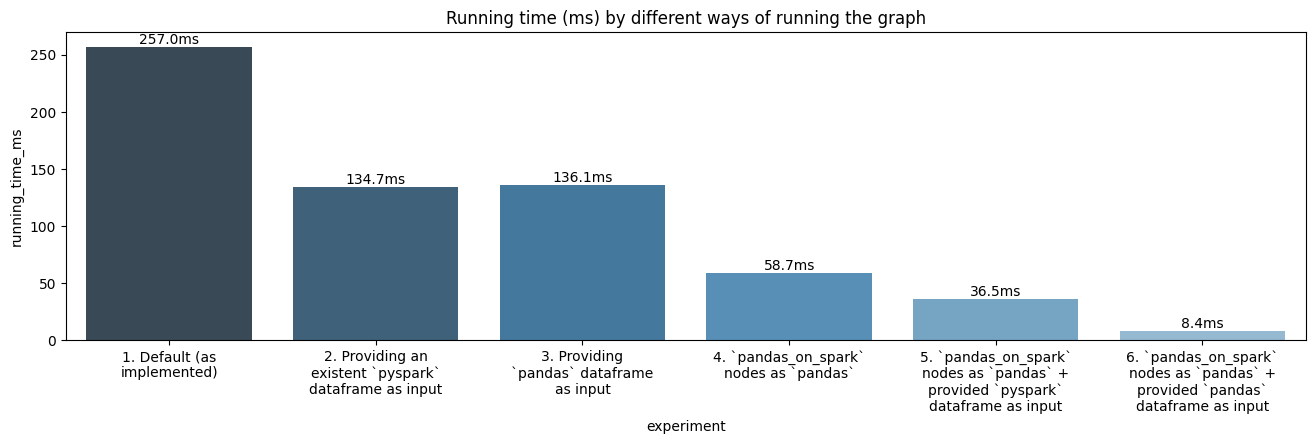

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(figsize=(16, 4))
pal = sns.color_palette("Blues_d", len(results))
barchart = (
    sns.barplot(x=results['experiment'], 
                y=results['running_time_ms'], 
                palette=np.array(pal[::-1]),
                ax=ax)
                .set(title='Running time (ms) by different ways of running the graph')
)
_ = ax.bar_label(ax.containers[0], fmt='%.1fms')

### Choosing the right run type

> These are only advices and it will dependend on the graph you are running and its purpose (if development, production big amount of data, production speed and small amount of data, etc).


1. **Default (as implemented)**

* Running pipelines
* Big volume of data

2. **Providing an existent `pyspark` dataframe as input**

* Debugging failed pipelines
* Last check before finishing development

3. **Providing `pandas` dataframe as input**

* Developing pipelines
* Extract a small set of data into a Pandas dataframe will be faster to run the pipeline multiple times during development

4. **`pandas_on_spark` nodes as `pandas`**

* Pipelines with small amount of data

5. **`pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input**

* Pipelines with small amount of data

6. **`pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input**

* When speed is important
* Small amount of data
* On demand feature generation
* Within APIs (running pipeline with data sent in requests)
* Unit tests (will avoid use of a spark session)